In [7]:
import pickle
import numpy as np
import pandas as pd
from itertools import groupby
from tqdm import tqdm_notebook
from scipy.optimize import curve_fit
from datetime import date, datetime, timedelta

import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = [10, 5]
%matplotlib notebook

In [658]:
with open("column_names.txt") as f:
    column_names = f.readlines()
column_names = column_names[0].split(',')

In [135]:
test_sock_off = [('AC000W001204540', '20170916'), ('AC000W001212809', '20180307'), ('AC000W001211941', '20180211'), ('AC000W000658842', '20161123'), ('AC000W000398460', '20170321'), ('AC000W000365980', '20170128'), 
                 ('AC000W000236258', '20170324'), ('AC000W001118182', '20180715'), ('AC000W000414548', '20170209'), ('AC000W000461567', '20170107'), ('AC000W001086996', '20170407'), ('AC000W000103039', '20161014'), 
                 ('AC000W001042034', '20171224'), ('AC000W000670414', '20180211'), ('AC000W000661143', '20160902'), ('AC000W001045532', '20170313'), ('AC000W000668914', '20160923'), ('AC000W000341549', '20170204'), 
                 ('AC000W000336510', '20161016'), ('AC000W000339336', '20170113'), ('AC000W001179577', '20170506'), ('AC000W000330907', '20160610'), ('AC000W000655511', '20170317'), ('AC000W001092503', '20180211'), 
                 ('AC000W001096216', '20170923'), ('AC000W000422937', '20170424'), ('AC000W002446952', '20180921'), ('AC000W000671067', '20160915'), ('AC000W000504597', '20161220'), ('AC000W001123677', '20180728'), 
                 ('AC000W001071988', '20180615'), ('AC000W001055680', '20171013'), ('AC000W000423996', '20161228'), ('AC000W001082216', '20170311'), ('AC000W000462074', '20170219'), ('AC000W000417819', '20170129'), 
                 ('AC000W000400671', '20180802'), ('AC000W001085332', '20170208')]

not_off = [('AC000W001184353', '20180208'), ('AC000W000672962', '20161205'), ('AC000W000452659', '20180324'), ('AC000W000339980', '20171118'), ('AC000W002428238', '20181006'), ('AC000W002580017', '20180729'), 
           ('AC000W001132677', '20160107'), ('AC000W000257571', '20160625'), ('AC000W000021330', '20160712'), ('AC000W002578613', '20180607'), ('AC000W001058273', '20180919')]

noisy_not_off = [('AC000W001058876', '20180817'), ('AC000W002430601', '20171105'), ('AC000W002430609', '20180903'), ('AC000W002431571', '20160103'), ('AC000W002577819', '20180413')]

noisy_off = [('AC000W000503700', '20170415'), ('AC000W001050870', '20170821'), ('AC000W000366042', '20161007'), ('AC000W000260438', '20160916'), ('AC000W000446448', '20160902'), ('AC000W002502642', '20180721'), 
             ('AC000W000253971', '20160515'), ('AC000W001052578', '20170924'), ('AC000W000337099', '20161222'), ('AC000W000421705', '20170426'), ('AC000W001040321', '20171126'), ('AC000W001203612', '20160105'), 
             ('AC000W001084878', '20170524'), ('AC000W000418343', '20160104'), ('AC000W000661800', '20180915'), ('AC000W002428977', '20180411'), ('AC000W001045040', '20180410'), ('AC000W001122268', '20170922'),
             ('AC000W001141068', '20180930'), ('AC000W000397544', '20161222'), ('AC000W000661765', '20170908'), ('AC000W000443281', '20170806')]

not_sure = [('AC000W000419427', '20170125'), ('AC000W000332422', '20161108'), ('AC000W001136285', '20180509'), ('AC000W001183543', '20180911'), ('AC000W000236258', '20161216'), ('AC000W002678759', '20180814'), 
            ('AC000W001056677', '20170614')]


In [986]:
not_off[8]

('AC000W000021330', '20160712')

In [4]:
def load_2sec(dsn, day, time_index=False):
    # Load 2 sec data
    df_2sec = pd.read_csv(f'16000_2sec/{day}/{dsn}.csv.zip', names=column_names)
    df_2sec.timestamp = pd.to_datetime(df_2sec.timestamp, unit='s')
    df_2sec = df_2sec.sort_values(by=['timestamp'])
    df_2sec.drop_duplicates('timestamp',inplace=True)

    # Think about what this does
    df_2sec = df_2sec.loc[(df_2sec.base_state > 3) & (df_2sec.ble_rssi != 0) & (df_2sec.heart_rate_raw >0)]
    
    df_2sec.reset_index(inplace=True, drop=True)
    
    if time_index:
        df_2sec.set_index('timestamp',inplace=True)
    
    return df_2sec

In [501]:
# Sock off: should 1st check if there is a yellow notification for sock off towards end*

def sock_off_diff(df, time_diff=180, thresh=-20):
    '''Plot the change in temperature and the moment the sock comes off if it does
    df - dataframe of last day data for a user'''
    diff_2_min = df.skin_temperature.diff(time_diff).fillna(0)
    less_than = diff_2_min.le(thresh)#.idxmax() # what if there is more than one??**
    less_than = less_than.index[less_than == True]
    
    if len(less_than) == 0: # If there is no sock off
        off = 0
    else:
#         off = diff_2_min.le(0).iloc[(less_than-time_diff):less_than].idxmax()
        diff_short = diff_2_min.iloc[:less_than[-1]]# need to go back more than just time_diff
        off = diff_short.index[diff_short == 0][-1]# + 180
#         if len(zero) != 0:
#             off = zero[-1]
#         else:
#             off = diff_short.index[0]
            
    df.set_index('timestamp',inplace=True) # What time was the sock taken off
    plot(df, off)
    
    
def ambient_numerical_estimation(df):
    # Is diff the same as dT/dt..?
    return df.skin_temperature + df.skin_temperature.diff(0).fillna(0) # temp * 2
  
def new_sock_off(df):
    diff_new = df.skin_temperature.diff().fillna(0)
    diff_rolling = diff_new.rolling(300).mean().fillna(method='bfill')
    
    # TODO: find ALL indices of min..
    if min(diff_rolling) <= -.05:
        # For each index:
        drop_index = diff_rolling.idxmin()
        off = diff_new.iloc[max(0,(drop_index-500)):drop_index]
        off = off.loc[off != 0]
        off_index_reset = off.eq(-1).reset_index().skin_temperature.rolling(window=4).sum().fillna(0).idxmax() - 3
        count_neg_1 = off.iloc[off_index_reset:].eq(-1).value_counts()
        #  if there are no False or no True:
        if len(count_neg_1) == 1:
            if count_neg_1.index[0]:
                off_index = off.index[off_index_reset]
        elif count_neg_1[True]/(count_neg_1[False] + count_neg_1[True]) >= .75:
            off_index = off.index[off_index_reset] # This is the index where the sock came off
        else:
            off_index = 0
    else:
        off_index = 0
    df = df.set_index('timestamp')
    plot(df, off_index)
    return off_index
    
def sock_off_newton(df, window=500, thresh=-.035):
    ambient = ambient_numerical_estimation(df)
    smooth = ambient.rolling(window=window).mean().fillna(method='bfill') # keep the same num of entries
    diff = smooth.diff().fillna(0)

    
    less_than = diff.le(thresh).idxmax() # Gives 1st instance of sock off 
#         find moment of sock off
    if less_than == 0:
        off = 0
    else:
        diff_short = diff.iloc[:less_than]
        off = diff_short.index[diff_short == 0][-1]
    
    
    # Get all sock off indices
#     less_than2 = list(diff.loc[diff <= thresh].index) #Only want 1st of consecutive
#     list_diff = np.diff(less_than2)
# #     print(np.where(list_diff > 1)[0])
#     indices = [less_than2[0], less_than2[np.where(list_diff > 300)[0][0]+1]]
#     print(indices)
#     if len(less_than2) != 0:
#         # loop through indices and get moment of sock off for each
#         off_list = []
#         for i in indices:
#             diff_short = diff.iloc[:i]
#             off_list.append(diff_short.index[diff_short == 0][-1])
#         print(off_list)
    

        
    return off
    
def plot(df, sock_off_x):
    '''Plot skin temp + sock off'''
    df.skin_temperature.apply(lambda x: x/2).plot()
    if sock_off_x != 0:
        x = df.index[sock_off_x]
        plt.plot(x, df[df.index == x].skin_temperature/2, 'r*')
    plt.show()

    
def plot_multiple(df, sock_off_xs):
    '''Plot skin temp + sock off'''
    df.skin_temperature.apply(lambda x: x/2).plot()
    if len(sock_off_xs) != 0: # If len == 0 there was no sock off detected.
        for i in sock_off_xs:
            x = df.index[i]
            plt.plot(x, df[df.index == x].skin_temperature/2, 'r*')
    plt.show()

In [882]:
def multiple_sock_off(df, thresh=-.05):
    diff_new = df.skin_temperature.diff().fillna(0)
    diff_rolling = diff_new.rolling(300).mean().fillna(method='bfill') # different window?
    off_indices = []
    
    # find ALL indices of min..
    if min(diff_rolling) <= thresh:
        less_than = diff_rolling[diff_rolling < thresh]
        drop_indices = [0] + list(np.where(np.diff(less_than.index.values) > 30)[0] + 1)
        drop_indices = less_than.index.values[drop_indices]
#         print('drop indices ', drop_indices)
        
        # For each index:
        for i in drop_indices:
#             print('i', i)
#             drop_index = diff_rolling.idxmin()
            if i == 0:
                off_indices.append(0)
            else:
                off = diff_new.iloc[max(0,(i-275)):i]
                off = off.loc[off != 0]
                off_index_reset = off.eq(-1).reset_index().skin_temperature.rolling(window=4).sum().fillna(0).idxmax() - 3
                count_neg_1 = off.iloc[off_index_reset:].eq(-1).value_counts()

                #  if there are no False or no True:
                if len(count_neg_1) == 1:
                    if count_neg_1.index[0]:
                        off_index = off.index[off_index_reset]
                        off_indices.append(off_index)
                elif count_neg_1[True]/(count_neg_1[False] + count_neg_1[True]) >= .7: # What threshhold?
#                     print('True/False ratio ',count_neg_1[True]/(count_neg_1[False] + count_neg_1[True]))
                    off_index = off.index[off_index_reset] # This is the index where the sock came off
                    off_indices.append(off_index)
            

    df = df.set_index('timestamp')
    plot_multiple(df, off_indices)
    return off_indices

In [661]:
t = 2
df_find_amb = load_2sec(noisy_off[t][0], noisy_off[t][1])
# ambient_temp = ambient_numerical_estimation(df_find_amb)
# ambient_temp.rolling(window=180).mean().dropna().plot()
# (ambient_temp/1000).plot()
df_find_amb.skin_temperature.plot()

In [1591]:
# ambient_temp.rolling(window=500).mean().fillna(method='bfill').plot()

In [1336]:
# df_2sec.skin_temperature.diff(180).fillna(0).plot()

AC000W001042034 20171224


<IPython.core.display.Javascript object>


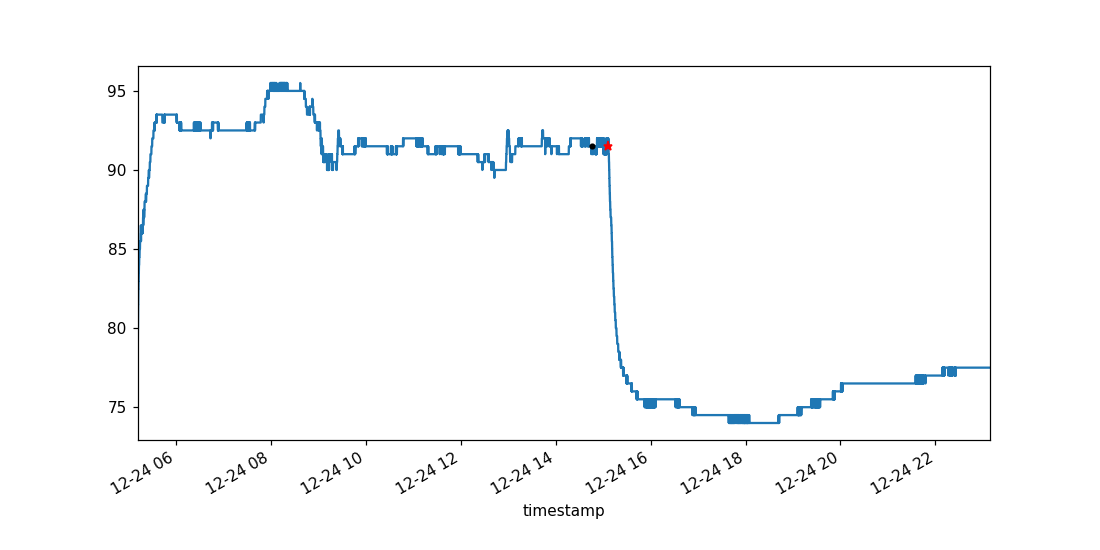

True


In [1034]:
test = 12
print(test_sock_off[test][0], test_sock_off[test][1])
df_new = load_2sec(test_sock_off[test][0], test_sock_off[test][1])
lost_signal_x = lost_signal(df_new)
# sock_off_x = new_sock_off(df_new)
sock_off_xs = multiple_sock_off(df_new)
print((df_new.timestamp[sock_off_xs[-1]] - df_new.timestamp[lost_signal_x]) > pd.Timedelta(minutes=5))
# print(df_new.timestamp[lost_signal_x])
plt.plot(df_new.timestamp[lost_signal_x], df_new.iloc[lost_signal_x].skin_temperature/2,'k.')

In [464]:
test = 6
df_2sec = load_2sec(not_off[test][0], not_off[test][1])
# sock_off_diff(df_2sec, thresh=-12) # df_2sec[-3600:].reset_index()
# df_2sec.skin_temperature.diff().rolling(300).sum().plot()

In [279]:
t_newton = 19
df_test = load_2sec(noisy_unknown[t_newton][0], noisy_unknown[t_newton][1])
off = sock_off_newton(df_test, thresh=-.05) # df_2sec[-3600:].reset_index()
# plot(df_test, off)
# print(off)

In [280]:
test2 = 0
print(test_sock_off[test2])
df_not_off = load_2sec(test_sock_off[test2][0], test_sock_off[test2][1])
# sock_off_diff(df_not_off, thresh=-12)

('AC000W001204540', '20170916')


In [1555]:
plt.plot(datetime(2017, 9,16, 10,59), 86, 'k.')

In [974]:
not_off[6]

('AC000W001132677', '20160107')

In [ ]:
# plt.plot(datetime(2016,11,23, 12,40), 90, 'k.') # point where signal was lost

In [704]:
# ambient_numerical_estimation(df_2sec).plot()

In [1477]:
# df_2sec.skin_temperature.diff(180).fillna(0).diff().plot()

<IPython.core.display.Javascript object>


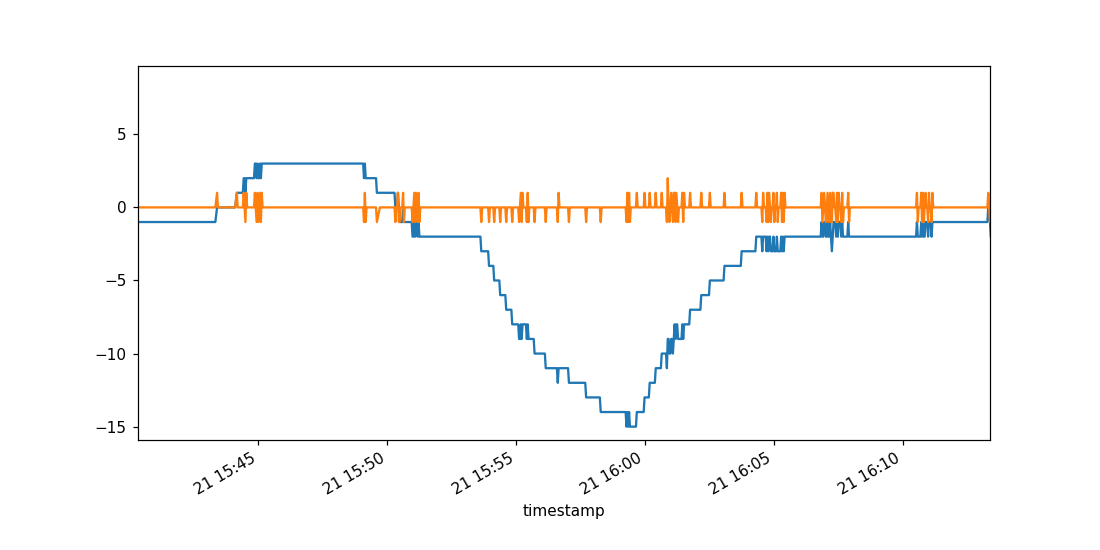

In [1476]:
df_2sec.skin_temperature.diff(180).fillna(0).plot()

- Try ignoring values that are the same
- Fit sigmoid
    - Diff to get derivative
- Frequency of -1s (it seems like the easiest way to observe this is diff(>0)

### Rolling avg for fit

<IPython.core.display.Javascript object>


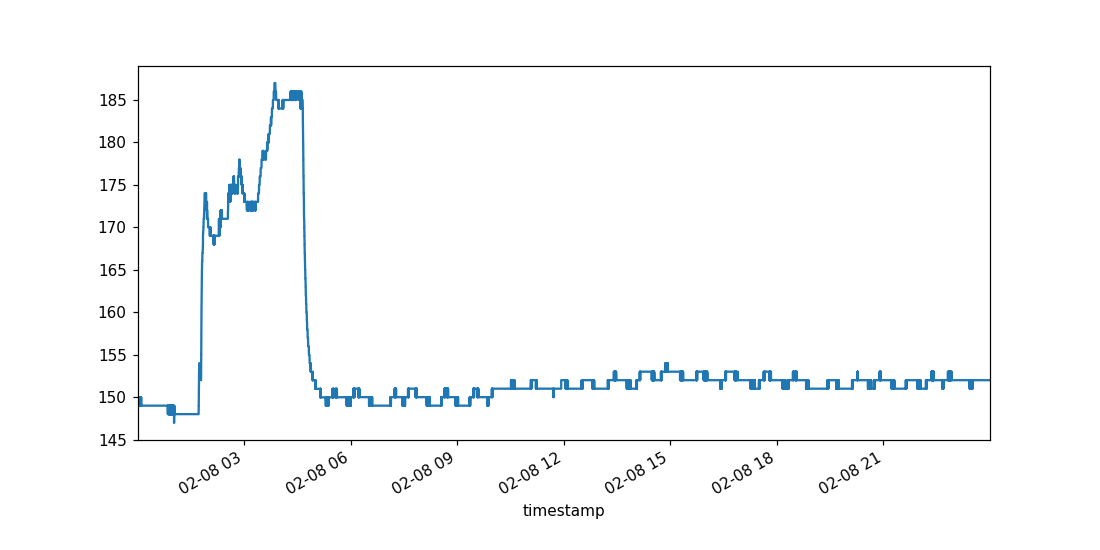

In [1446]:
(df_2sec.skin_temperature + df_2sec.skin_temperature.rolling(window=1800).mean().fillna(150).diff()).plot()

## Fit sigmoid

In [680]:
df_test_fit = load_2sec(test_sock_off[5][0], test_sock_off[5][1])
def sigmoid(x, x0, k, a, c):
    y = a / (1 + np.exp(-k*(x-x0))) + c
    return y

xdata = df_test_fit.index.values[6467:10300]
ydata = df_test_fit.skin_temperature.values[6467:10300]
popt, pcov = curve_fit(sigmoid, xdata, ydata, p0=[8315, -.0085, 30, 136])


<IPython.core.display.Javascript object>


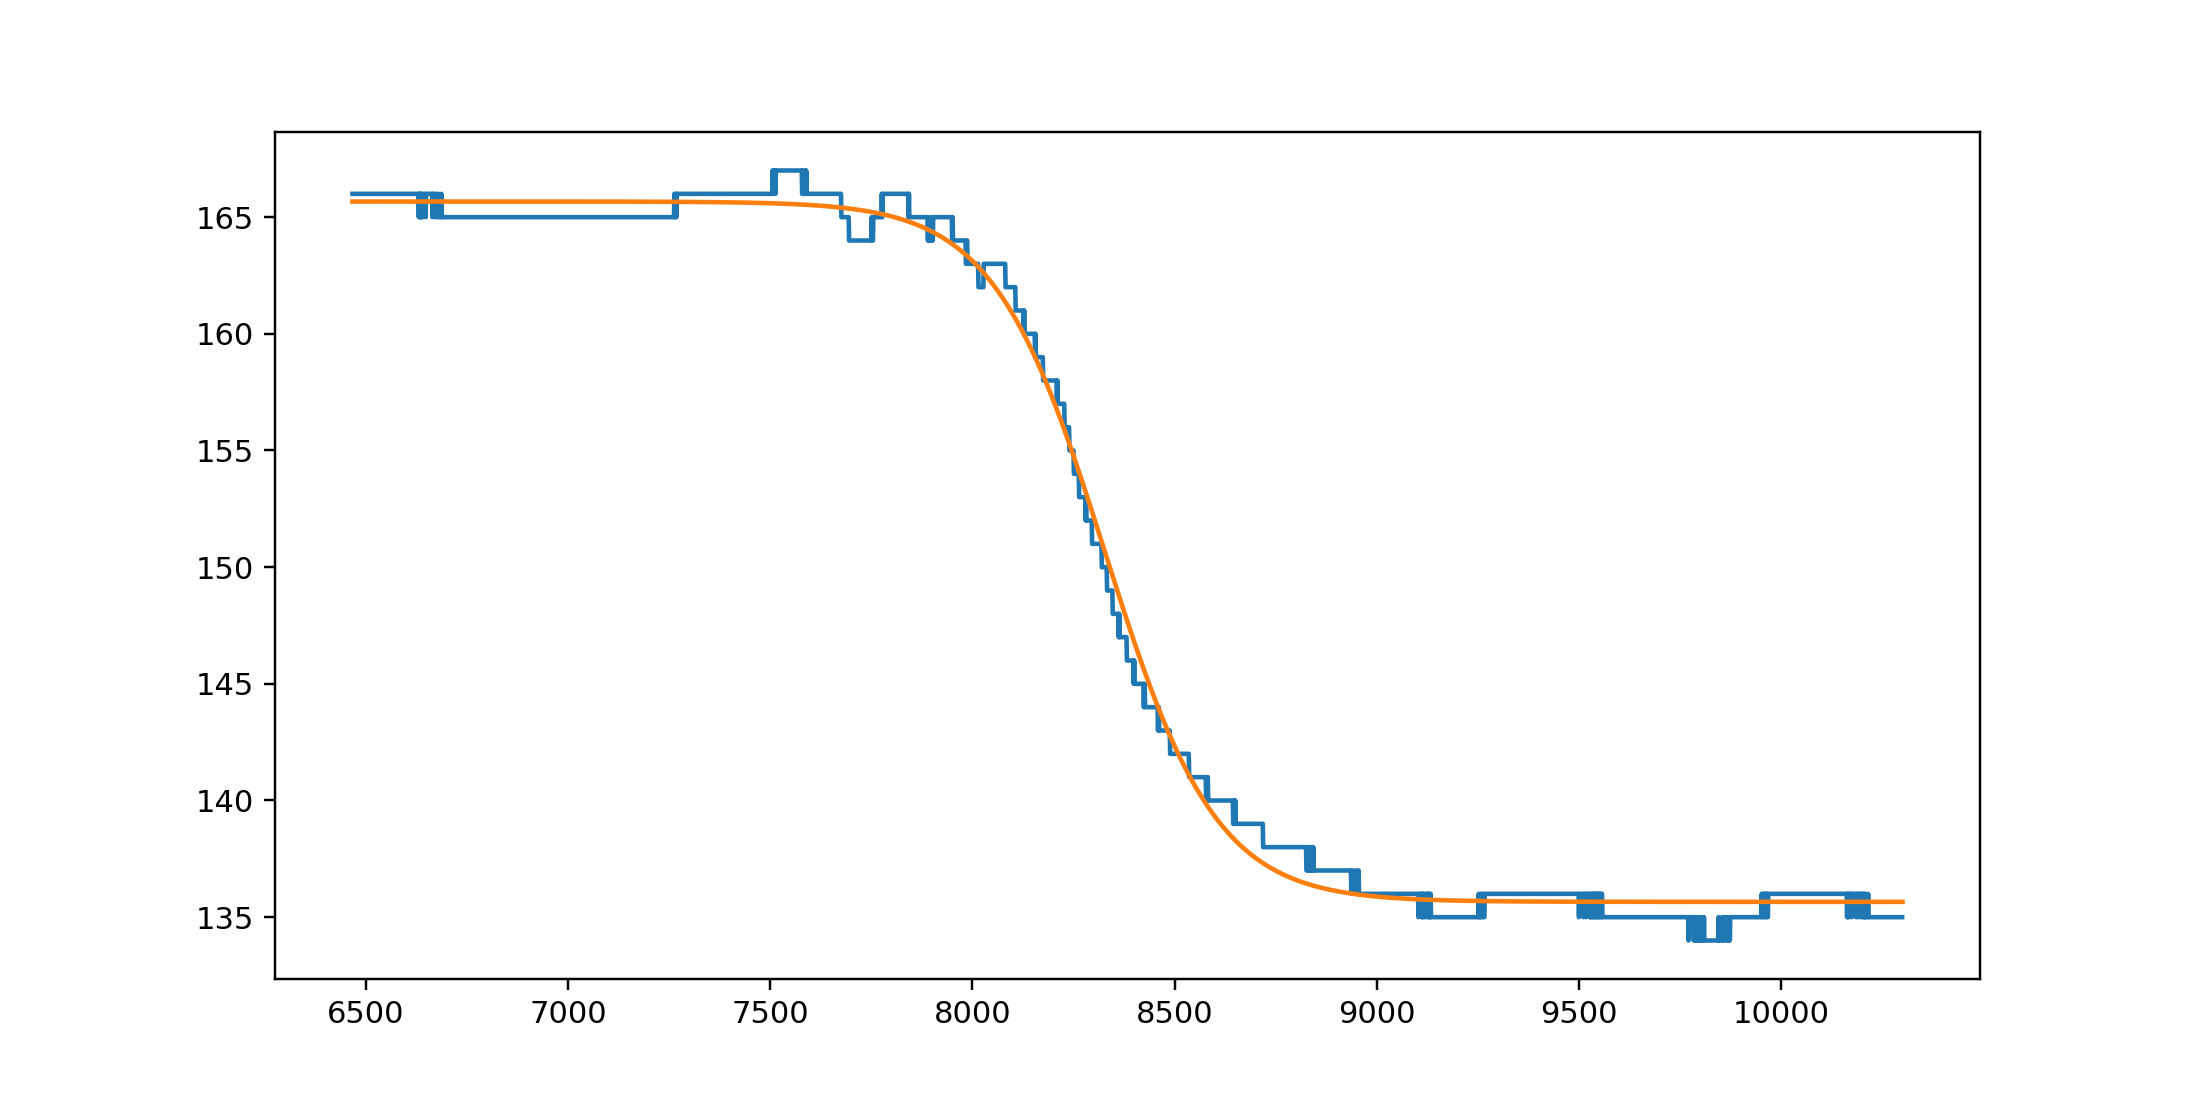

In [692]:
x = np.linspace(6467, 10300, 3833)
y = sigmoid(x, *popt)

plt.plot(xdata, ydata, label='data')
plt.plot(x,y, label='fit')

In [682]:
popt

array([ 8.32749151e+03, -7.25871579e-03,  3.00147144e+01,  1.35656370e+02])

<IPython.core.display.Javascript object>


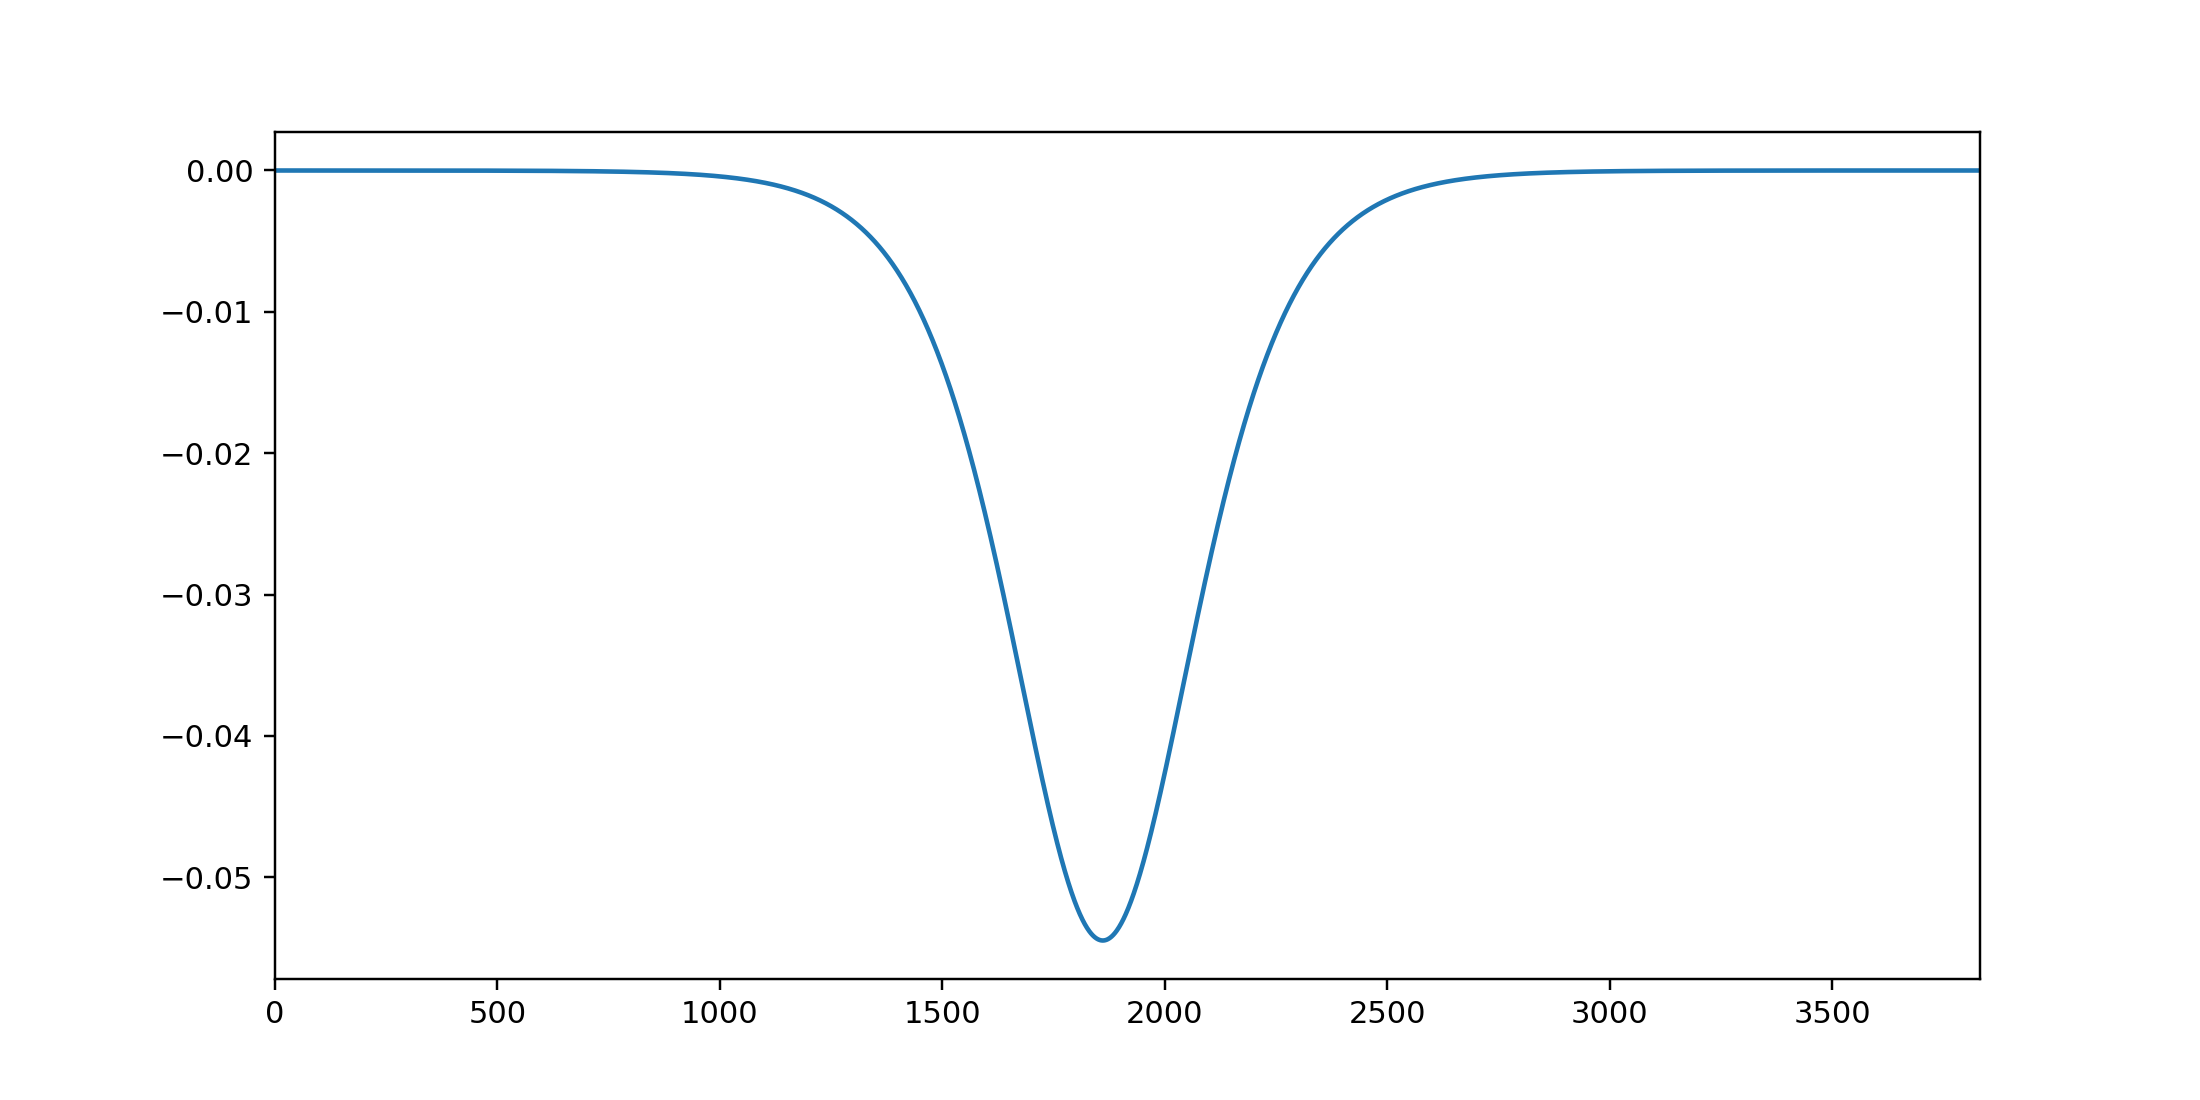

In [702]:
pd.Series(y).diff().fillna(0).plot()

<IPython.core.display.Javascript object>


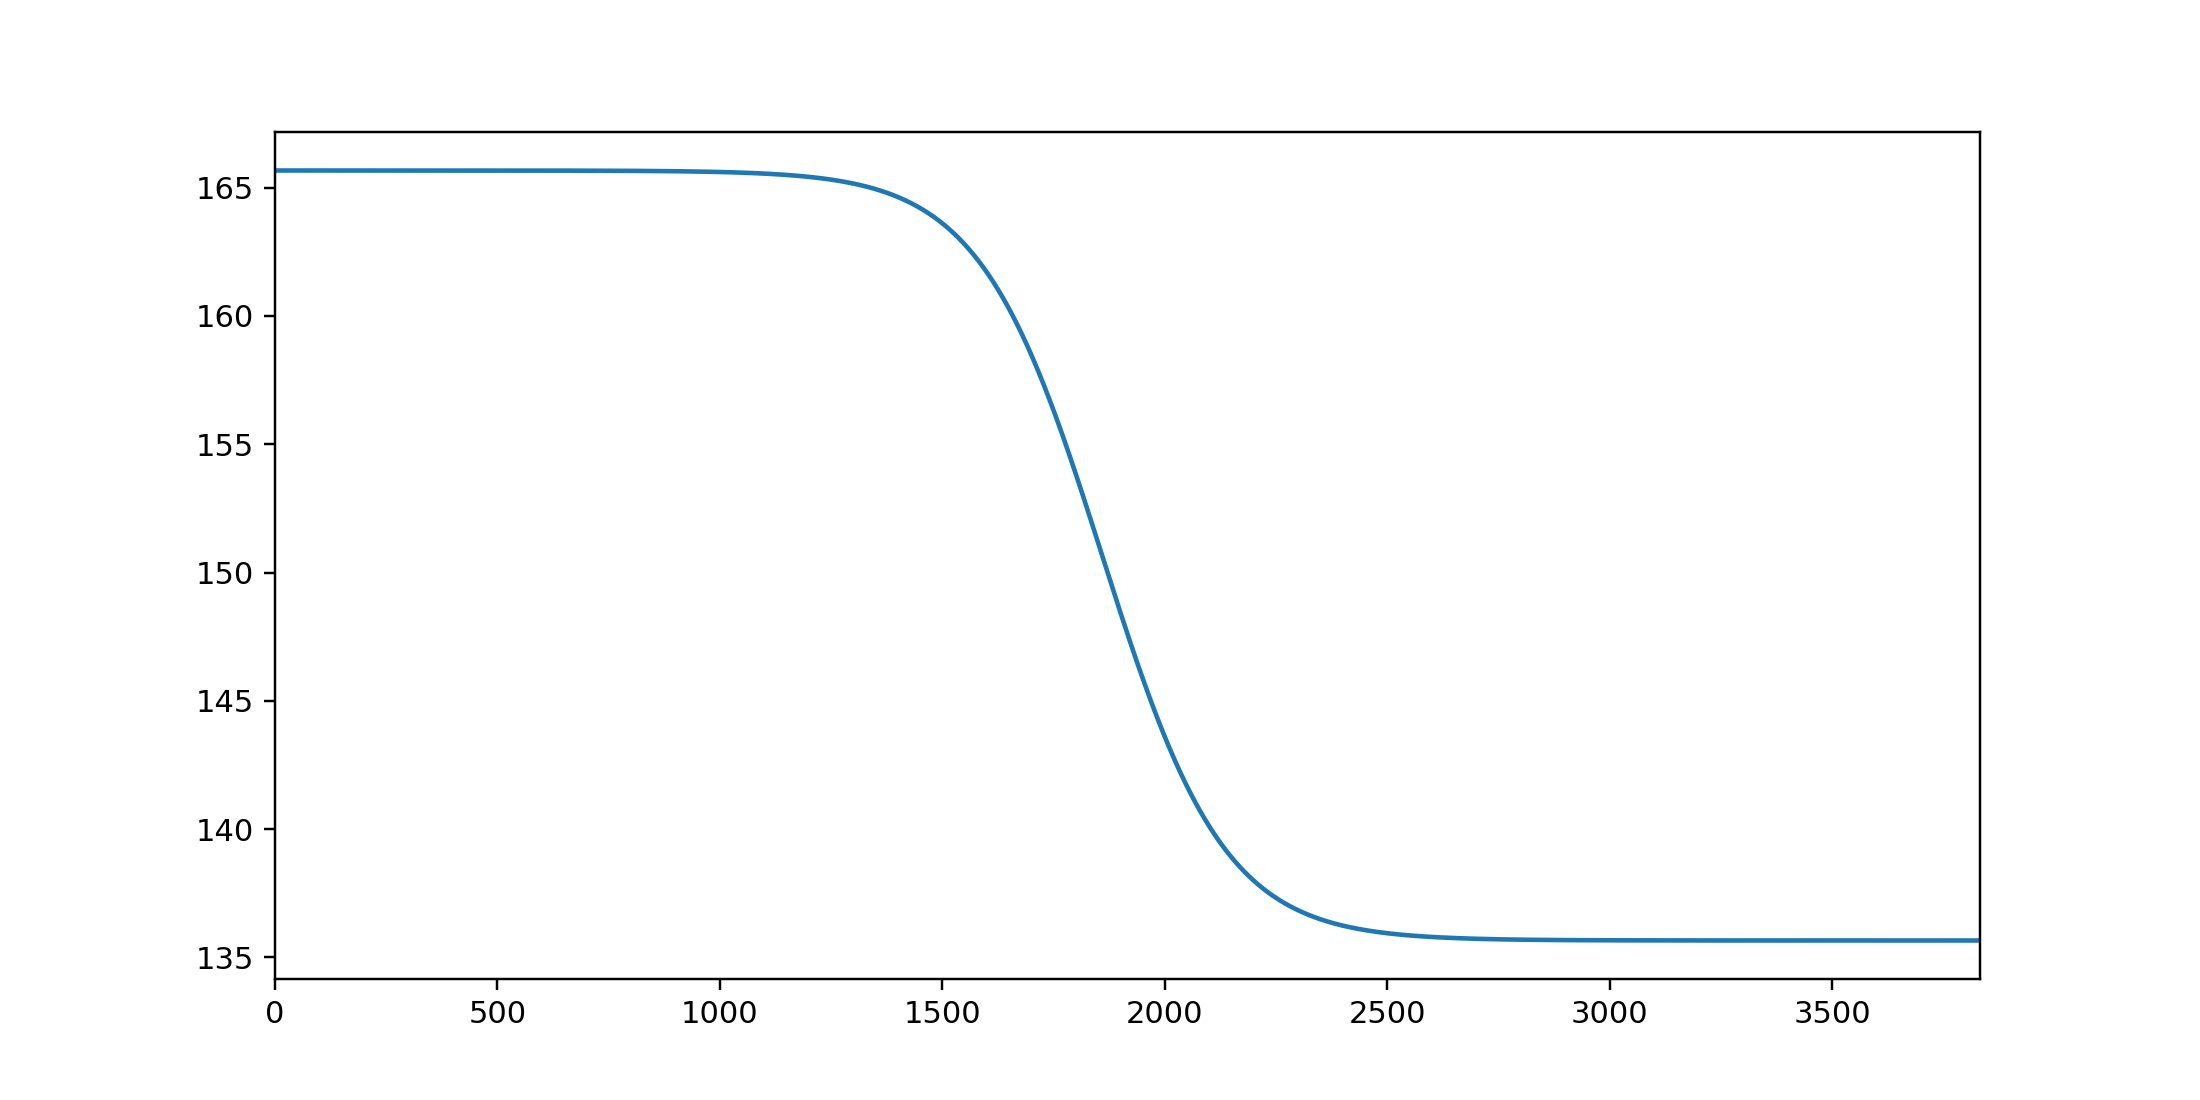

In [703]:
(y + pd.Series(y).diff().fillna(0)).plot()

In [489]:
df_test_fit.index.values

array([    0,     1,     2, ..., 38033, 38034, 38035])

In [605]:
df_test_cool = load_2sec(test_sock_off[5][0], test_sock_off[5][1])
def cooling(x, b, c, k, a):
    return c*np.exp(-k*(x + b)) + a

xdata2 = df_test_cool.index.values[8100:10300]
ydata2 = df_test_cool.skin_temperature.values[8100:10300]
popt, pcov = curve_fit(sigmoid, xdata2, ydata2, p0=[-8750, 1, .0055, 135])

/Users/brodriguez/miniconda3/envs/py36/lib/python3.6/site-packages/scipy/optimize/minpack.py:787: OptimizeWarning: Covariance of the parameters could not be estimated
  category=OptimizeWarning)


In [606]:
x2 = np.linspace(8000, 10300, 2200)
y2 = sigmoid(x2, *popt)

plt.plot(xdata2, ydata2, label='data')
plt.plot(x2,y2, label='fit')

In [611]:
plt.plot(x2, cooling(x2, -8750, 1, .0055, 135))

<IPython.core.display.Javascript object>


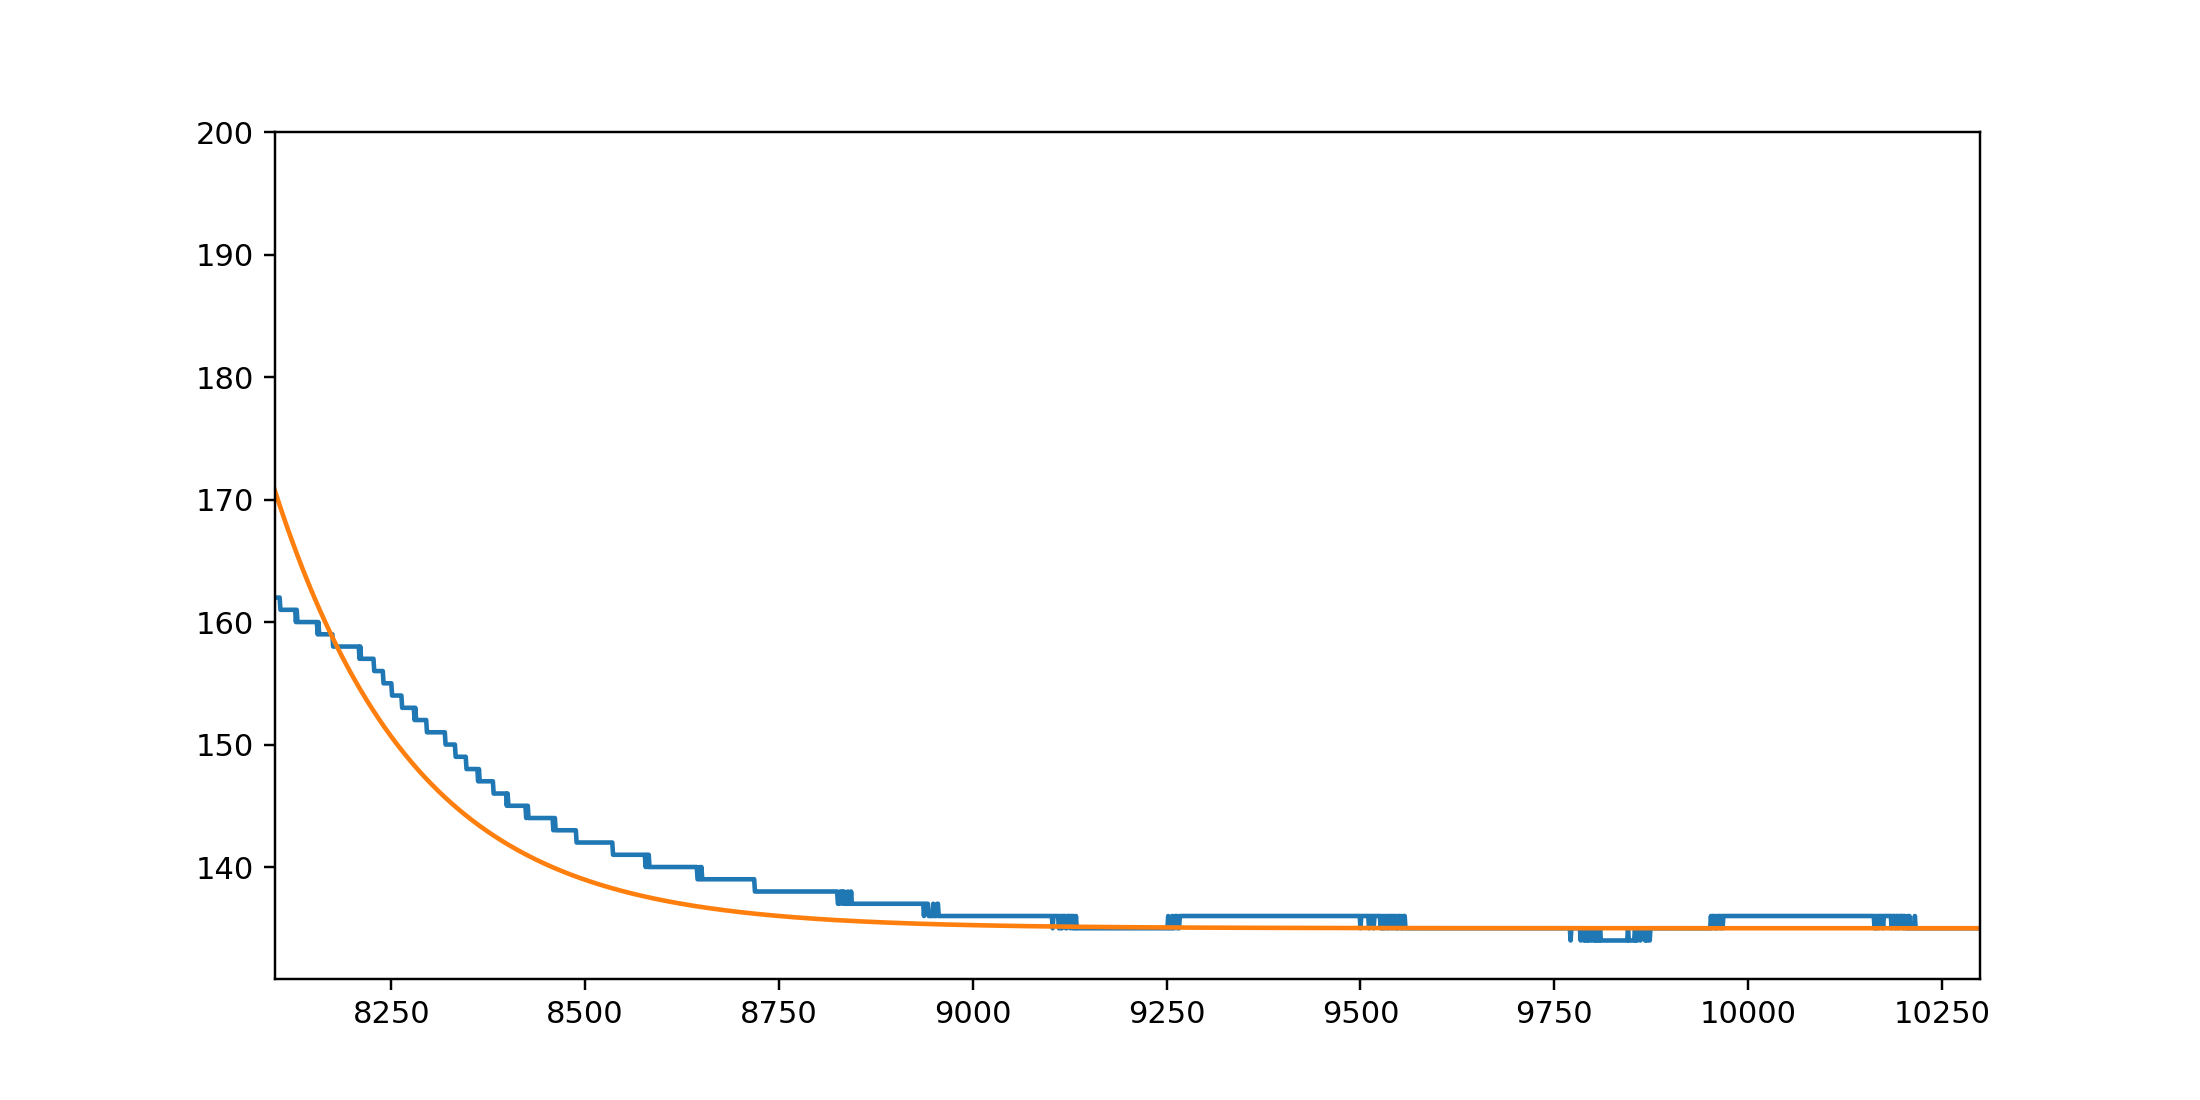

In [610]:
df_test_cool.skin_temperature.iloc[8100:10300].plot()

## Drop consecutive duplicate values

In [509]:
df_2sec.skin_temperature.values

array([139, 139, 139, ..., 137, 137, 137])

In [513]:
skin_temp_no_dup = [x[0] for x in groupby(df_2sec.skin_temperature.values)]

<IPython.core.display.Javascript object>


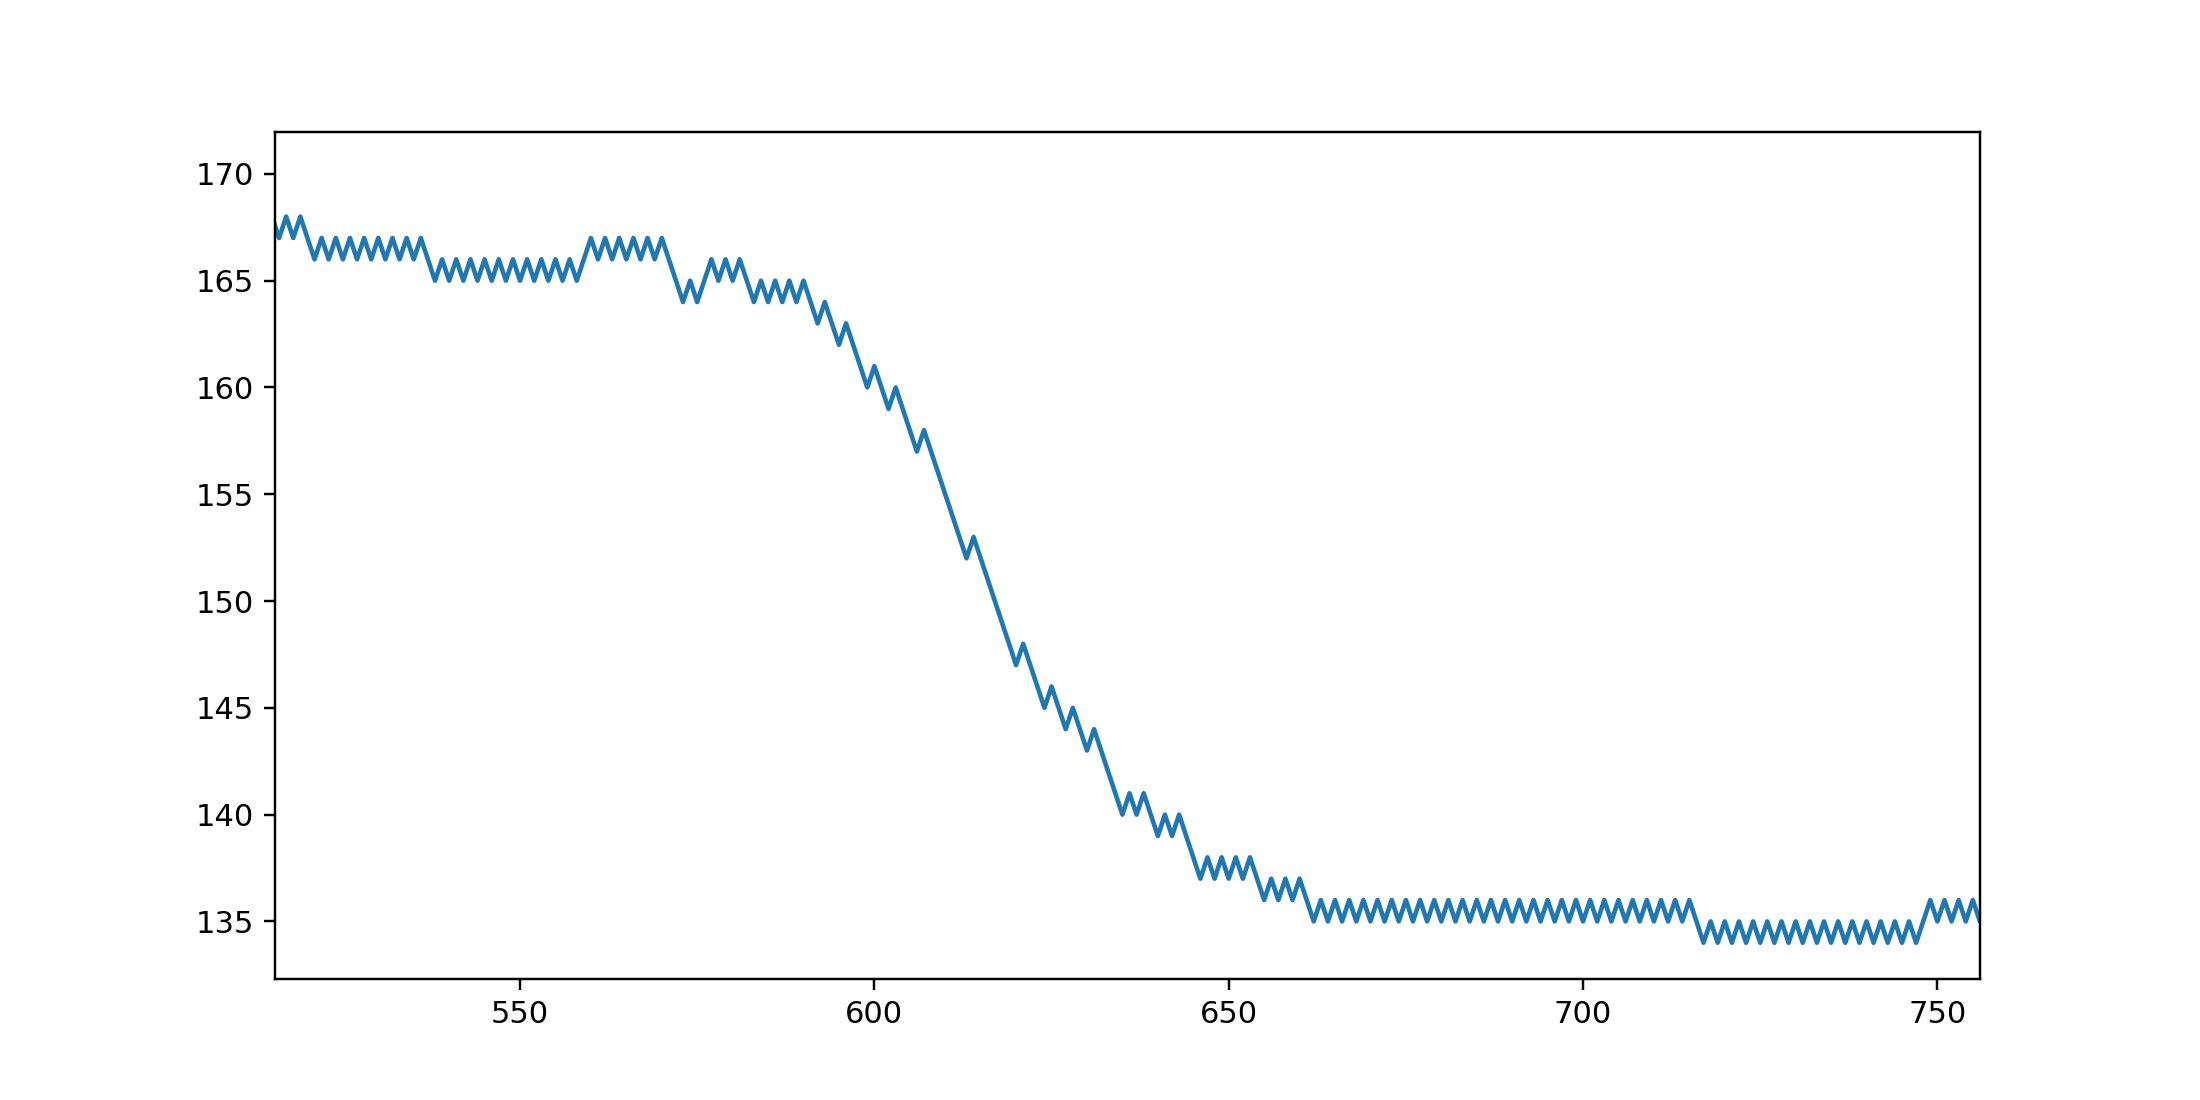

In [514]:
plt.plot(np.linspace(0, len(skin_temp_no_dup)-1, len(skin_temp_no_dup)), skin_temp_no_dup)

In [193]:
# df_2sec.iloc[:].skin_temperature.diff(periods=180).fillna(0).plot()

In [156]:
# df_2sec.skin_temperature.diff().fillna(0).plot()

## Convolution

<IPython.core.display.Javascript object>


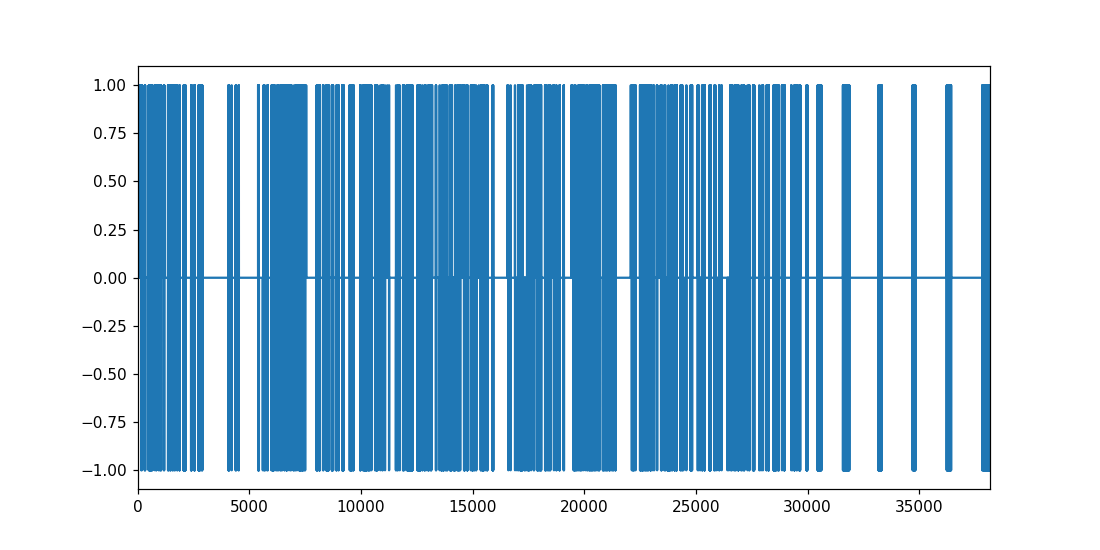

In [1604]:
t_conv = 1
data = load_2sec(noisy_unknown[t_conv][0], noisy_unknown[t_conv][1]).skin_temperature
d = data.diff().plot()
# gap_size = 180
# split = np.array_split(d, int(d.shape[0]/gap_size))
# differences = [np.sum(series.values) for series in split]
# pd.Series(differences).plot()

# BAd because a drop in temp is penalized if there is a strong increase close by

I think I care more about how many 0's are in between -1's

In [52]:
count = 0
all_counts = []
for i in df_2sec.skin_temperature.diff().fillna(0).values:
    if i == 0:
        count += 1
    elif count != 0:
        all_counts.append(count)
        count = 0

In [58]:
# all_counts
# plt.plot(np.linspace(0,len(all_counts)-1, len(all_counts)), all_counts)
# plt.show()

In [98]:
df_2sec.iloc[24860]

index                                 21492
dsn                         AC000W002678759
timestamp               2018-08-10 13:54:22
heart_rate_raw                          160
heart_rate_avg                          166
oxygen_raw                               93
oxygen_avg                               93
movement_raw                             14
battery_level                            30
alerts_mask                               0
notification_mask                     32838
skin_temperature                        196
red_led_current                          50
ir_led_current                           19
timeout_code                              0
seq_number                               24
accelerometer_temp                       36
fast_timers                               1
data_age                                  1
aux_channel_1                            10
aux_channel_2                            92
ore_indicator                             0
base_state                      

In [133]:
# Gives the first index where diff < -30 (want the preceeding diff == 0)
df_2sec.skin_temperature.diff(180).fillna(0).le(-30).idxmax()


24997

In [129]:
df_2sec.skin_temperature.diff(180).fillna(0).le(0).iloc[24817:24997].idxmax()

24859

In [131]:
plt.plot(24859, 0, 'k*')

In [100]:
# df_2sec.index.get_loc(df_2sec.skin_temperature.diff(180).fillna(0).le(-30).idxmax())

24997

In [ ]:
df.index.get_loc(consecutive.idxmin())

In [174]:
diff = 1
save = []
for i in df_2sec.iloc[:].skin_temperature.replace(to_replace=0,method='ffill').diff().fillna(0):
    if i != 0:
        if np.sign(diff) != np.sign(i):
            diff = i
            save.append(0)
        else:
            save.append(i)
    else:
        save.append(0)

In [175]:
plt.plot(np.linspace(0,len(save)-1,len(save)), save)
plt.show()

In [178]:
np.linspace(0,len(save)-1,len(save))

array([0.0000e+00, 1.0000e+00, 2.0000e+00, ..., 3.2591e+04, 3.2592e+04,
       3.2593e+04])

In [176]:
len(save)

32594

## Signal Loss

In [256]:
count = 0
all_counts = []
for i in df_2sec.notification_mask.values:#.ne(0).iloc[3015:3100]
    if i != 0:
        count += 1
    elif count != 0:
        all_counts.append(count)
        count = 0

<IPython.core.display.Javascript object>


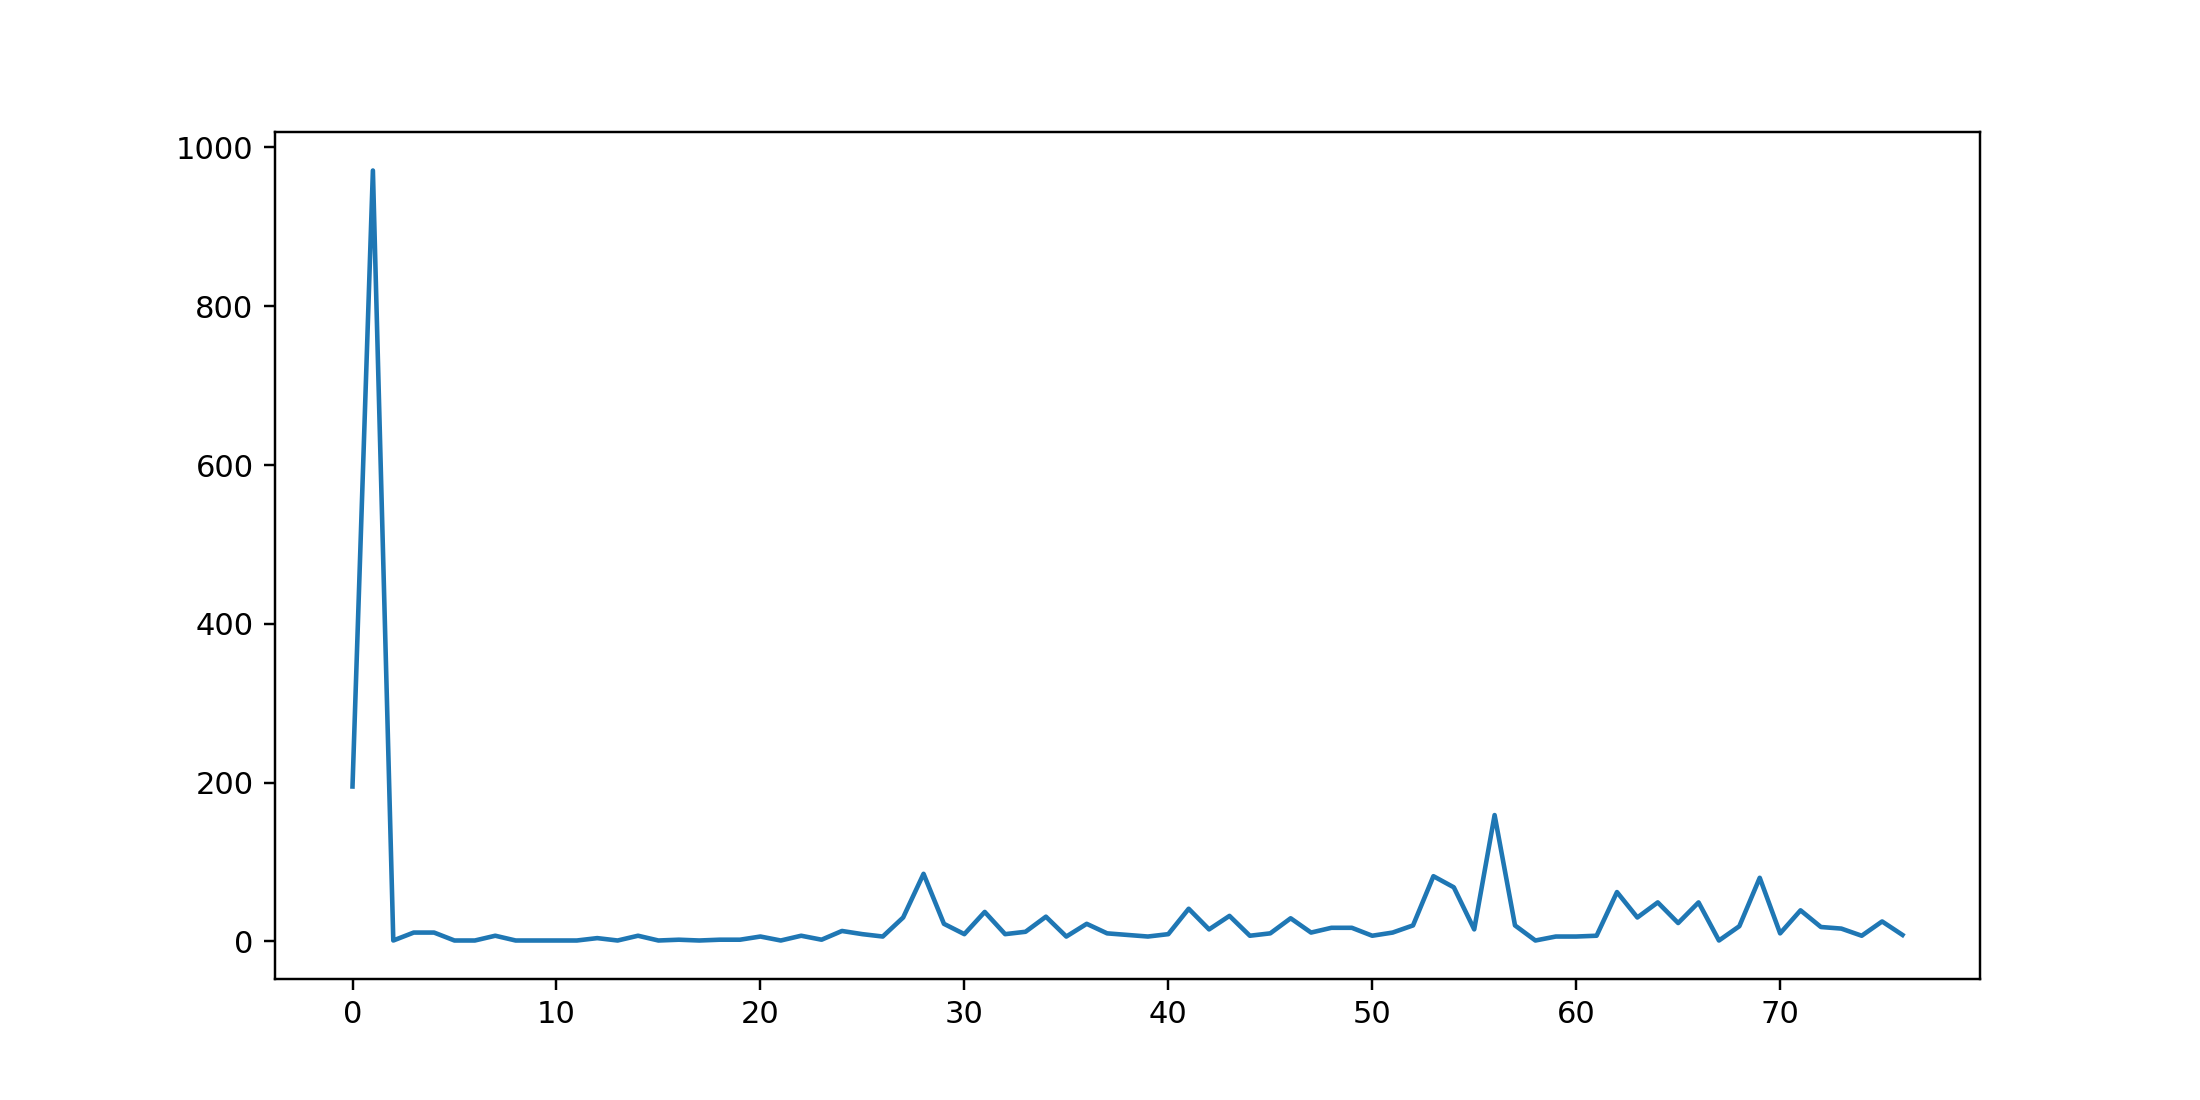

In [257]:
plt.plot(np.linspace(0,len(all_counts)-1, len(all_counts)), all_counts)
plt.show()

In [270]:
df_2sec[df_2sec.notification_mask == 0].timestamp.diff().fillna(pd.Timedelta(seconds=0)).abs().le(pd.Timedelta(2,'s'))

195      True
196      True
197      True
1169    False
1171    False
1172     True
1173     True
1174     True
1175     True
1176     True
1177     True
1178     True
1179     True
1180     True
1181     True
1182     True
1183     True
1195    False
1207    False
1208     True
1209     True
1210     True
1211     True
1212     True
1213     True
1214     True
1215     True
1216     True
1217     True
1218     True
        ...  
3195     True
3196     True
3197     True
3198     True
3199     True
3200     True
3201     True
3202     True
3203     True
3204     True
3205     True
3206     True
3207     True
3208     True
3209     True
3210     True
3211     True
3251    False
3270    False
3271     True
3272     True
3273     True
3274     True
3275     True
3276     True
3293    False
3301    False
3302     True
3328    False
3337    False
Name: timestamp, Length: 759, dtype: bool

In [272]:
df_2sec.iloc[3276]

index                                 15368
dsn                         AC000W000236258
timestamp               2017-03-24 20:45:08
heart_rate_raw                          108
heart_rate_avg                          111
oxygen_raw                               90
oxygen_avg                               90
movement_raw                              0
battery_level                            96
alerts_mask                               0
notification_mask                         0
skin_temperature                        185
red_led_current                          32
ir_led_current                            9
timeout_code                              0
seq_number                               42
accelerometer_temp                       30
fast_timers                               0
data_age                                  7
aux_channel_1                             0
aux_channel_2                             0
ore_indicator                             0
base_state                      

In [273]:
df_signal = load_2sec('AC000W000260438', '20160916')

In [274]:
df_signal[df_signal.notification_mask == 0].timestamp.diff().fillna(pd.Timedelta(seconds=0)).abs().le(pd.Timedelta(2,'s'))

339      True
340      True
370     False
371      True
380     False
381      True
412     False
418     False
419      True
473     False
500     False
501      True
502      True
503      True
590     False
613     False
614      True
616     False
617      True
678     False
708     False
709      True
711     False
712      True
774     False
801     False
804     False
805      True
807     False
808      True
        ...  
4535    False
4538    False
4540    False
4558    False
4559     True
4560     True
4561     True
4564    False
4565     True
4566     True
4567     True
4568     True
4569     True
4572    False
4573     True
4577    False
4613    False
4614     True
4615     True
4619    False
4620     True
4621     True
4624    False
4625     True
4627    False
4628     True
4629     True
4630     True
4631     True
4633    False
Name: timestamp, Length: 1495, dtype: bool

In [275]:
df_signal.iloc[4631]

index                                  4607
dsn                         AC000W000260438
timestamp               2016-09-16 05:22:26
heart_rate_raw                          148
heart_rate_avg                          151
oxygen_raw                               59
oxygen_avg                               57
movement_raw                              1
battery_level                            94
alerts_mask                               4
notification_mask                         0
skin_temperature                        160
red_led_current                           9
ir_led_current                            6
timeout_code                              0
seq_number                               16
accelerometer_temp                       26
fast_timers                               0
data_age                                 17
aux_channel_1                             0
aux_channel_2                             0
ore_indicator                             0
base_state                      

In [280]:
df_10_min = pickle.load(open('16000_dfs/AC000W000260438_df.p', 'rb'))
valid_df = df_10_min.loc[df_10_min.valid_count > 0]
df_day = valid_df.loc[(valid_df.index > '2016-09-16 00:00:00') & (valid_df.index < '2016-09-16 23:59:59')]
valid_percent = df_day.valid_count/df_day['count']

In [285]:
for i in valid_percent.values[::-1]:
    print(i)
    if i > .1:
        index = valid_percent[valid_percent == i].index
        print(index)
        break

0.087248322147651
0.12203389830508475
DatetimeIndex(['2016-09-16 05:10:00+00:00'], dtype='datetime64[ns, UTC]', name='timestamp', freq=None)


In [296]:
approximate_signal_loss = valid_percent[valid_percent > .1].index[-1] + timedelta(minutes=10)# + 10 min

Timestamp('2016-09-16 05:20:00+0000', tz='UTC')

In [33]:
def signal_loss(df_day):
    # Already got rid of valid_count = 0
    valid_percent = df_day.valid_count/df_day['count']
    return valid_percent[valid_percent > .1].index[-1] + timedelta(minutes=10)
# TODO need to account for change to base 3 charging, 
    #if base3 is true and that is the last one, the signal is lost during the 10 min interval
    
def signal_loss_1_min(df_day):
    # already got rid of vitals = 0
    
    def count_valid_reads(array_like):
        return np.sum(array_like == 0)/len(array_like)

    group = df_day[['notification_mask']].resample("1T")
    df_valid_count = group.apply(count_valid_reads)
    df_valid_count.columns = ['valid_percent']
    
    # Care about time signal was lost and the skin_temp at that time
    return df_valid_count[df_valid_count.valid_percent >= .5].index[-1] 

#Problem.. there could be a minute of valid data but if it is split in 2 it could look like 2 .5% valid

In [73]:
consecutive_valid = df_day_2_sec.notification_mask.eq(0).rolling(window=35).sum().fillna(0)

In [75]:
consecutive_valid[consecutive_valid>15]#.index[-1]

timestamp
2017-02-08 01:58:44    16.0
2017-02-08 01:58:46    16.0
2017-02-08 01:58:48    16.0
2017-02-08 01:58:50    17.0
2017-02-08 01:58:52    18.0
2017-02-08 01:58:54    19.0
2017-02-08 01:58:56    20.0
2017-02-08 01:58:58    21.0
2017-02-08 01:59:00    20.0
2017-02-08 01:59:02    19.0
2017-02-08 01:59:04    18.0
2017-02-08 01:59:06    17.0
2017-02-08 01:59:08    16.0
2017-02-08 01:59:10    16.0
2017-02-08 01:59:12    16.0
2017-02-08 01:59:14    17.0
2017-02-08 01:59:16    18.0
2017-02-08 01:59:18    19.0
2017-02-08 01:59:20    20.0
2017-02-08 01:59:22    21.0
2017-02-08 01:59:24    20.0
2017-02-08 01:59:26    19.0
2017-02-08 01:59:28    19.0
2017-02-08 01:59:30    18.0
2017-02-08 01:59:32    18.0
2017-02-08 01:59:34    17.0
2017-02-08 01:59:36    17.0
2017-02-08 01:59:38    16.0
2017-02-08 02:01:06    16.0
2017-02-08 02:01:08    17.0
                       ... 
2017-02-08 04:28:30    27.0
2017-02-08 04:28:32    27.0
2017-02-08 04:28:34    28.0
2017-02-08 04:28:36    29.0
2017-02-08

In [37]:
# signal_loss(df_day)

In [69]:
df_day_2_sec = load_2sec('AC000W001204540', '20170916', time_index=True)
# signal_loss_1_min(df_day_2_sec)

In [ ]:
plt.plot(datetime(2016,11,23, 12,40), 90, 'k.')

In [76]:
j=2
for i in test_sock_off:
    df_day_2_sec = load_2sec(i[0], i[1], time_index=True)
    # bigger window?
    consecutive_valid = df_day_2_sec.notification_mask.eq(0).rolling(window=16).sum().fillna(0)
    print(j, consecutive_valid[consecutive_valid>=15].index[-1])
    j+=1

2 2017-09-16 10:47:11
3 2018-03-07 14:22:02
4 2018-02-11 01:33:44
5 2016-11-23 12:35:46
6 2017-03-21 03:15:58
7 2017-01-28 06:50:39
8 2017-03-24 20:42:06
9 2018-07-15 07:04:11
10 2017-02-09 14:49:59
11 2017-01-07 05:02:39
12 2017-04-07 15:18:58
13 2016-10-14 04:15:25
14 2017-12-24 14:45:58
15 2018-02-11 13:27:47
16 2016-09-02 08:40:45
17 2017-03-13 00:27:37
18 2016-09-23 10:12:25
19 2017-02-04 14:24:18
20 2016-10-16 07:15:07
21 2017-01-13 14:33:37
22 2017-05-06 03:35:29
23 2016-06-10 11:43:21
24 2017-03-17 21:28:50
25 2018-02-11 13:11:38
26 2017-09-23 11:35:49
27 2017-04-24 14:48:30
28 2018-09-21 05:28:18
29 2016-09-15 07:58:06
30 2016-12-20 16:38:45
31 2018-07-28 12:51:22
32 2018-06-15 12:31:10
33 2017-10-13 09:37:00
34 2016-12-28 11:00:01
35 2017-03-11 09:47:03
36 2017-02-19 09:47:19
37 2017-01-29 13:20:28
38 2018-08-02 05:00:13
39 2017-02-08 04:28:52


In [620]:
def lost_signal(df):
    consecutive_valid = df.notification_mask.eq(0).rolling(window=16).sum().fillna(0)
    if consecutive_valid[consecutive_valid>=15].shape[0] == 0:
        return 0
    return consecutive_valid[consecutive_valid>=15].index[-1]

In [162]:
lost_signal(df_2sec)

5157

In [1057]:
def binary(x):
    '''Convert int to binary and return indices of bits that are 1'''
    bi = list(bin(x)[2:])[::-1]
    indices = np.where(np.array(bi) == "1")[0]
    return indices

def map_indices(x):
    '''Return list of notifications based on binary of the given int'''
    indices = binary(x)
    notification_mask = {0:"sock off",
                          1:"movement",
                          2:"buffer reset",
                          3:"HR out of range",
                          4:"signal saturating DC amplifier",
                          5:"signal saturating DC amplifier",
                          6:"signal saturating DC amplifier",
                          7:"signal saturating DC amplifier",
                          8:"signal saturating DC amplifier",
                          9:"signal saturating DC amplifier",
                          10:"DC signal low",
                          11:"LED adjusting",
                          12:"low pulse amplitude",
                          13:"AC Ambient Signal is Too High",
                          14:"O2 out of range",
                          15:"Invalid HR"}
    notifications = []
    for i in range(len(indices)):
        # Find out which flags are active
        notifications.append(notification_mask[indices[i]])
    if len(notifications) == 0:
        return ["Good"]
    return list(set(notifications))

In [1058]:
map_indices(33060)#36865

['signal saturating DC amplifier', 'buffer reset', 'Invalid HR']

In [1059]:
bin(33060)

'0b1000000100100100'

In [1045]:
bin(32804)

'0b1000000000100100'

In [ ]:
tomas_notification_mask = [36852, 35718]
erma_notification_mask = [36865]